In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

print(tf.__version__)

2.1.0


In [2]:
dataset_path = os.path.join("dataset", "35288-STMALO-Statistiques-Web-Quotidien.csv")
df = pd.read_csv(dataset_path, sep=";")
df.head()

,Jour,Visites,Visiteurs uniques,Pages vues
0,01/01/2012,906,807,2184
1,02/01/2012,1655,1404,4234
2,03/01/2012,1728,1484,4574
3,04/01/2012,1604,1370,4123
4,05/01/2012,1885,1578,4663


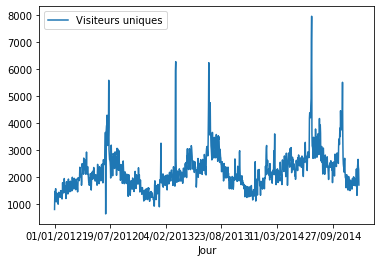

In [3]:
df.plot("Jour", "Visiteurs uniques")

In [4]:
series = np.array(df["Visites"])
dates = df["Jour"]
len_time = len(dates)
time = np.arange(len_time)
split_time = int(len_time*0.5)

print("There are {} days in the dataset.".format(len_time))
print("Split time : {}".format(split_time))

# Normalize series
series = (series - np.mean(series))/np.max(series)

# Train/Validation split
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

There are 1096 days in the dataset.
Split time : 548


In [5]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)
np.random.seed(0)

window_size = 32
batch_size = 128
shuffle_buffer_size = 2000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="same",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(1, activation="tanh"),
  tf.keras.layers.Lambda(lambda x: x * 2)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5.e-5)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=250)

Epoch 1/250
5/5 [==============================] - 4s 839ms/step - loss: 0.0028 - mae: 0.0531
Epoch 2/250
5/5 [==============================] - 0s 30ms/step - loss: 0.0033 - mae: 0.0489
Epoch 3/250
5/5 [==============================] - 0s 34ms/step - loss: 0.0022 - mae: 0.0452
Epoch 4/250
5/5 [==============================] - 0s 38ms/step - loss: 0.0022 - mae: 0.0433
Epoch 5/250
5/5 [==============================] - 0s 38ms/step - loss: 0.0022 - mae: 0.0420
Epoch 6/250
5/5 [==============================] - 0s 41ms/step - loss: 0.0019 - mae: 0.0401
Epoch 7/250
5/5 [==============================] - 0s 38ms/step - loss: 0.0019 - mae: 0.0391
Epoch 8/250
5/5 [==============================] - 0s 38ms/step - loss: 0.0017 - mae: 0.0391
Epoch 9/250
5/5 [==============================] - 0s 37ms/step - loss: 0.0024 - mae: 0.0392
Epoch 10/250
5/5 [==============================] - 0s 33ms/step - loss: 0.0020 - mae: 0.0410
Epoch 11/250
5/5 [==============================] - 0s 40ms/step - l

5/5 [==============================] - 0s 43ms/step - loss: 0.0014 - mae: 0.0336
Epoch 89/250
5/5 [==============================] - 0s 33ms/step - loss: 0.0015 - mae: 0.0335
Epoch 90/250
5/5 [==============================] - 0s 34ms/step - loss: 0.0014 - mae: 0.0335
Epoch 91/250
5/5 [==============================] - 0s 36ms/step - loss: 0.0014 - mae: 0.0333
Epoch 92/250
5/5 [==============================] - 0s 43ms/step - loss: 0.0023 - mae: 0.0333
Epoch 93/250
5/5 [==============================] - 0s 44ms/step - loss: 0.0015 - mae: 0.0350
Epoch 94/250
5/5 [==============================] - 0s 57ms/step - loss: 0.0026 - mae: 0.0339
Epoch 95/250
5/5 [==============================] - 0s 43ms/step - loss: 0.0015 - mae: 0.0352
Epoch 96/250
5/5 [==============================] - 0s 29ms/step - loss: 0.0021 - mae: 0.0351
Epoch 97/250
5/5 [==============================] - 0s 27ms/step - loss: 0.0016 - mae: 0.0354
Epoch 98/250
5/5 [==============================] - 0s 36ms/step - loss: 

5/5 [==============================] - 0s 30ms/step - loss: 0.0019 - mae: 0.0311
Epoch 175/250
5/5 [==============================] - 0s 32ms/step - loss: 0.0015 - mae: 0.0365
Epoch 176/250
5/5 [==============================] - 0s 25ms/step - loss: 0.0012 - mae: 0.0322
Epoch 177/250
5/5 [==============================] - 0s 31ms/step - loss: 0.0019 - mae: 0.0342
Epoch 178/250
5/5 [==============================] - 0s 31ms/step - loss: 0.0014 - mae: 0.0347
Epoch 179/250
5/5 [==============================] - 0s 29ms/step - loss: 0.0014 - mae: 0.0322
Epoch 180/250
5/5 [==============================] - 0s 30ms/step - loss: 0.0012 - mae: 0.0316
Epoch 181/250
5/5 [==============================] - 0s 35ms/step - loss: 0.0012 - mae: 0.0324
Epoch 182/250
5/5 [==============================] - 0s 38ms/step - loss: 0.0014 - mae: 0.0319
Epoch 183/250
5/5 [==============================] - 0s 30ms/step - loss: 0.0012 - mae: 0.0311
Epoch 184/250
5/5 [==============================] - 0s 31ms/ste

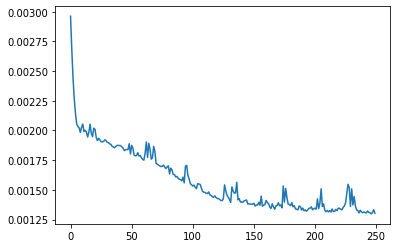

In [9]:
plt.plot(np.arange(len(history.history["loss"])), history.history["loss"])

MAE : 0.04198780655860901


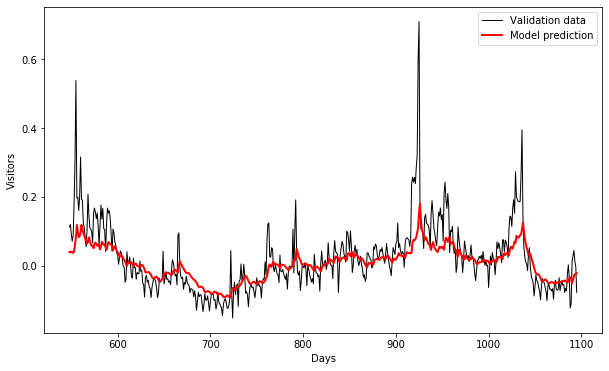

In [10]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid, "k", linewidth=1, label="Validation data")
plt.plot(time_valid, rnn_forecast, "r", linewidth=2, label="Model prediction")
plt.xlabel("Days")
plt.ylabel("Visitors")
plt.legend()

print("MAE : {}".format(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()))